## Clasificador plantas.
#### Hecho por: José Ignacio Salas Cáceres

En este programa se ha elaborado una red neuronal que pueda clasificar entre 10 plantas de la flora española.  
El dataset usado cuenta con 10 clases de 200 imágenes aprox. cada uno.  
Las imágenes de todo el grupo excepto el girasol proceden del Banco taxonómico Digital de la Flora Ibérica de la web Biodiversidadvirtual.org  (https://www.biodiversidadvirtual.org/herbarium/)    
Las imágenes del girasol proceden del dataset "Flower Recognition" de kaggle. (https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

El listado de plantas usado, con nombre científico y común, es el siguiente: 

 + n1 = Papaver rhoeas, Amapola
 + n2 = Aphyllanthes monspeliensis, chunqueta
 + n3 = Helianthus annuus, Girasol
 + n4 = Astragalus incanus, Piorno
 + n5 = Campanula rapunculus, Campanilla
 + n6 = Gynandriris sisyrinchium, lirio
 + n7 = Lonicera etrusca, madreselva
 + n8 = Oxalis pes crapae, Trebolina
 + n9 = Paronychia capitata, Hierba plateada
 + n10 = Vincetoxicum hirundinaria, Matatósico

#### Cambios con respecto a la anterior versión.

 Con respecto a la anterior versión, se ha añadido una capa convolutiva más, se ha aumentado el batch size, el dropout y la paciencia. Se puede ver que debido a estos cambios tarda muchisimo más en entrenarse pero llega a mejores resultados. No ha ni triggereado el early stopping

In [1]:
#Como estamos usando Google Colab, vamos a acceder a las imágenes a través de Google Drive.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


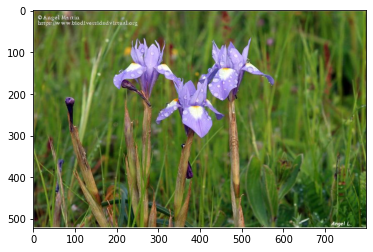

In [2]:
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf

#Mostramos una imagen del conjunto como ejemplo

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab/Dataset_Plantas/n6/Gynandriris-sisyrinchium-(L.)-Parl.-498515.sm.jpg', 'r')
imshow(np.asarray(pil_im))


In [3]:
# DATA SOURCE --------------------------------------------------

image_size = (300,300)
batch_size = 100
_names = ['n1', 'n10', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
nombres = ['amapola','matatósico','chunqueta','girasol','Piorno','Campanula','lirio','MadreSelva','Trebolina','Hierba plateada']

# Ambos conjuntos estan en diferentes carpetas dentro de google drive.

# Defino el conjunto de entrenamiento con sus caracteristicas. Como son flores, necesitaremos las imagenes en rgb y como hay varias clases
# el label mode será categorical y no binary.



train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab/Dataset_Plantas",
    image_size=image_size,
    color_mode='rgb',
    batch_size=batch_size,
    label_mode='categorical',
    class_names = _names,
    shuffle = True
)

# Defino el conjunto de validacion

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab/Validacion_plantas",
    image_size=image_size,
    color_mode='rgb',
    batch_size=batch_size,
    label_mode='categorical',
    class_names = _names,
    shuffle = False
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 1560 files belonging to 10 classes.
Found 400 files belonging to 10 classes.


In [4]:
# MODELO SIN TRANSFER LEARNING

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Como no vamos a aplicar transfer learning simplemente crearemos el modelo de 0.
# Primero lo declaramos secuencial e insertamos la entrada. Despues ponemos capas de redes convolutivas.
# Al final aplicamos flatten al vector resultante y lo insertamos en una red fully-connected.

model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1, 
                    input_shape=(300, 300, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



In [5]:
# TRAINING --------------------------------------------------

# Compilamos el modelo y especificamos la funcion de error (entropia cruzada) y el metodo de oprimizacion, el adam.
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

# Definimos elnumero de epocas
epochs = 50

# Definimos las condiciones para el early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8, restore_best_weights=True)

#entrenamos el modelo.

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/50
16/16 [==============================] - 320s 11s/step - loss: 3.1792 - accuracy: 0.1128 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/50
16/16 [==============================] - 10s 478ms/step - loss: 2.2999 - accuracy: 0.0987 - val_loss: 2.2972 - val_accuracy: 0.1050
Epoch 3/50
16/16 [==============================] - 10s 483ms/step - loss: 2.2743 - accuracy: 0.1103 - val_loss: 2.2591 - val_accuracy: 0.1375
Epoch 4/50
16/16 [==============================] - 11s 487ms/step - loss: 2.2058 - accuracy: 0.1577 - val_loss: 2.1980 - val_accuracy: 0.1475
Epoch 5/50
16/16 [==============================] - 11s 523ms/step - loss: 2.1551 - accuracy: 0.2135 - val_loss: 2.1499 - val_accuracy: 0.2625
Epoch 6/50
16/16 [==============================] - 11s 483ms/step - loss: 2.1046 - accuracy: 0.2487 - val_loss: 2.0384 - val_accuracy: 0.3025
Epoch 7/50
16/16 [==============================] - 11s 485ms/step - loss: 1.9701 - accuracy: 0.3045 - val_loss: 1.9358 - val_accuracy: 0.2875


4/4 [==============================] - 0s 42ms/step
              precision    recall  f1-score   support

           0     0.7949    0.7750    0.7848        40
           1     0.6410    0.6250    0.6329        40
           2     0.4286    0.5250    0.4719        40
           3     0.8372    0.9000    0.8675        40
           4     0.7200    0.4500    0.5538        40
           5     0.3400    0.4250    0.3778        40
           6     0.8667    0.3250    0.4727        40
           7     0.4783    0.5500    0.5116        40
           8     0.7000    0.7000    0.7000        40
           9     0.6667    0.9000    0.7660        40

    accuracy                         0.6175       400
   macro avg     0.6473    0.6175    0.6139       400
weighted avg     0.6473    0.6175    0.6139       400



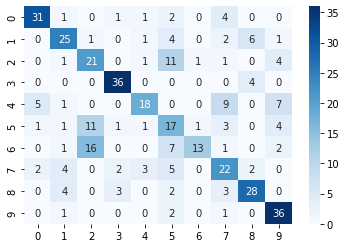

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#Realizado el entrenamiento, vamos a crear la matriz de confusion para entender mejor los resultados.



results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[1], axis=1)
labels = np.argmax(results[0], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

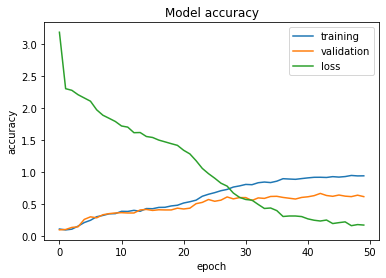

In [7]:
import matplotlib.pyplot as plt

# Vamos a graficar tambien la variacion de las precisiones y del loss con las epochs.

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 193ms/step
Hierba plateada


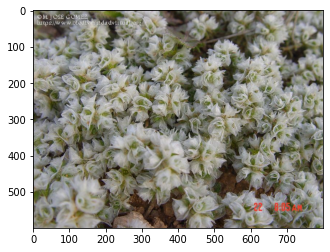

In [8]:
#Esto es simplemente una prueba con imagenes fuera del conjunto de entrenamiento y prueba.

nombres = ['amapola','matatósico','chunqueta','girasol','Piorno','Campanula','lirio','MadreSelva','Trebolina','Hierba plateada']

img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Colab/Predicciones/laura.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

pil_im = Image.open('/content/drive/My Drive/Colab/Predicciones/laura.jpg', 'r')
imshow(np.asarray(pil_im))
predictions = model.predict(img_array)
print(nombres[np.argmax(predictions)])